# Jollibee, KFC, or Macdonalds Detector

## install dependencies

In [1]:
import fastbook
fastbook.setup_book()

In [5]:
from fastbook import *
from fastai.vision.widgets import *

## Download the image by bing image search api

### Set the env for api key here

In [21]:
import os
key = os.environ.get('AZURE_SEARCH_KEY', 'KEY_HERE')

In [22]:
chicken_types = 'mcdonald', 'kfc', 'jollibee'
path = Path('chiken')

### Get each chiken images by its name holder

In [23]:
if not path.exists():
    path.mkdir()
    for o in chicken_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} chicken')
        download_images(dest, urls=results.attrgot('contentUrl'))

### Clearn data by deleting invalid image

In [24]:
fns = get_image_files(path)
fns

(#391) [Path('chiken/kfc/00000054.jpg'),Path('chiken/kfc/00000120.jpg'),Path('chiken/kfc/00000141.jpg'),Path('chiken/kfc/00000023.jpg'),Path('chiken/kfc/00000016.jpg'),Path('chiken/kfc/00000010.jpg'),Path('chiken/kfc/00000004.jpg'),Path('chiken/kfc/00000104.jpg'),Path('chiken/kfc/00000060.jpg'),Path('chiken/kfc/00000125.png')...]

In [25]:
failed = verify_images(fns)
failed

/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:2966: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:2966: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:2966: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:2966: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


(#7) [Path('chiken/kfc/00000089.jpg'),Path('chiken/kfc/00000102.jpg'),Path('chiken/kfc/00000114.jpg'),Path('chiken/mcdonald/00000079.jpg'),Path('chiken/mcdonald/00000069.jpg'),Path('chiken/jollibee/00000129.jpg'),Path('chiken/jollibee/00000049.jpg')]

In [26]:
failed.map(Path.unlink);

### See images

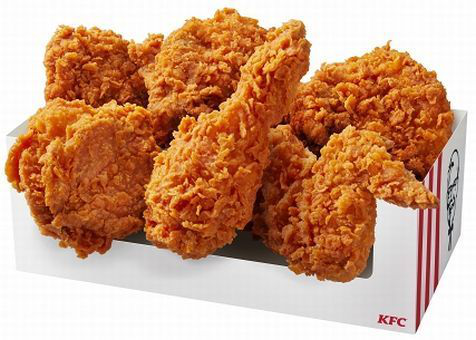

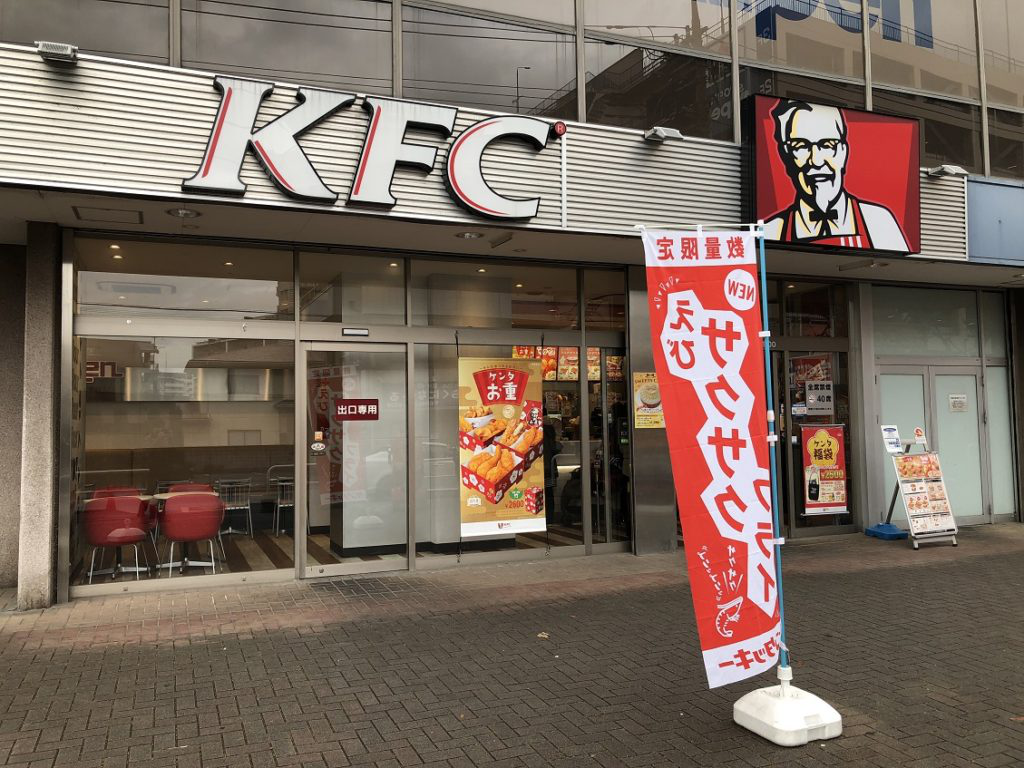

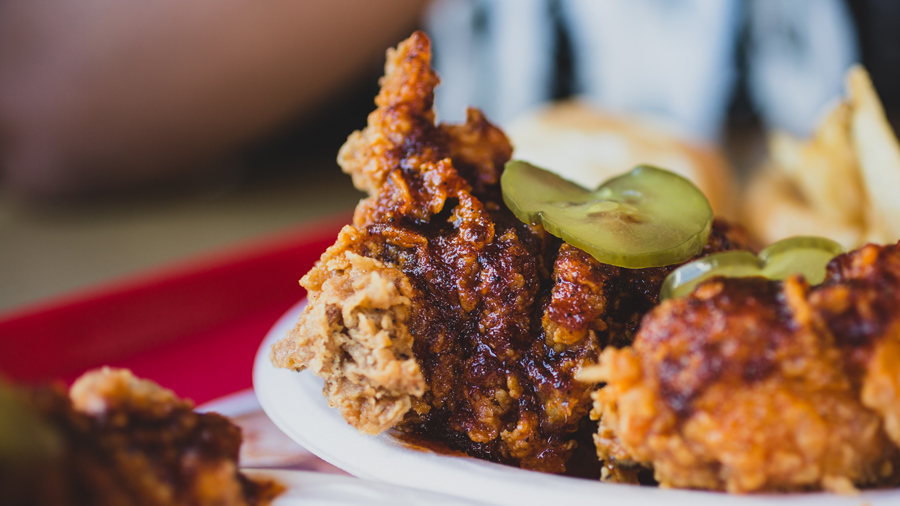

In [42]:
for i in fns[:3]:
    im = Image.open(i)
    im.show()

## Change Data to DataLoaders

### Make DataBlock

In [47]:
chickens = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [48]:
dls = chickens.dataloaders(path)

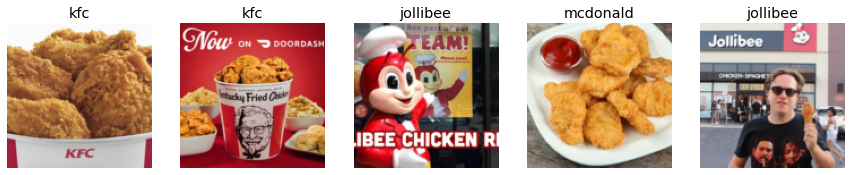

In [50]:
dls.valid.show_batch(max_n=5, nrows=1)

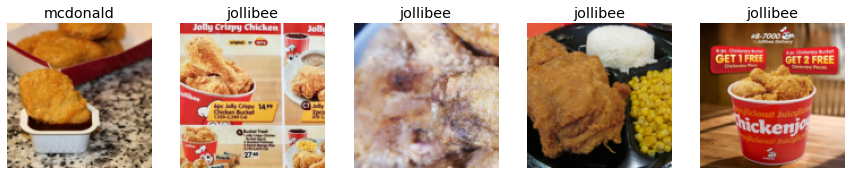

In [51]:
dls.train.show_batch(max_n=5, nrows=1)

## Data Augmentation

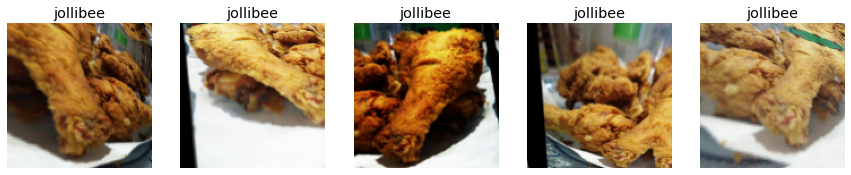

In [54]:
chickens = chickens.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = chickens.dataloaders(path)
dls.train.show_batch(max_n=5, nrows=1, unique=True)

## Train the model, and using it to clearn chicken data

In [55]:
chickens = chickens.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = chickens.dataloaders(path)

### Make CNN learner

In [56]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.986424,1.579746,0.552632,00:07


/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,1.420472,1.167771,0.421053,00:07
1,1.324791,1.011528,0.342105,00:07
2,1.193586,0.971582,0.315789,00:07
3,1.069575,0.960358,0.276316,00:07
4,0.968347,0.947090,0.276316,00:07


/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:

### Identify which images model mispredict

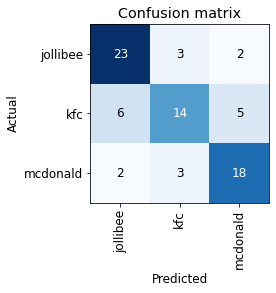

In [57]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Visualize mispredicted images

In [60]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [61]:
# Delete or amend train data
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Make inference modelm

### Save the model

In [63]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

### Load model

In [64]:
learn_inf = load_learner(path/'export.pkl')
learn_inf.predict(fns[0])

('kfc', tensor(1), tensor([4.5339e-03, 9.9525e-01, 2.1542e-04]))

In [65]:
# Show categorical variables
learn_inf.dls.vocab

['jollibee', 'kfc', 'mcdonald']

## Creating a notebook app

In [78]:
btn_upload = widgets.FileUpload()
btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [79]:
# handler func
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128, 128))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    
btn_run.on_click(on_click_classify)

In [80]:
VBox([widgets.Label('Select your chicken!'),
     btn_upload, btn_run, out_pl, lbl_pred])

In [81]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     |████████████████████████████████| 1.6 MB 16.7 MB/s eta 0:00:01
     |████████████████████████████████| 389 kB 31.9 MB/s eta 0:00:01
     |████████████████████████████████| 82 kB 2.5 MB/s s eta 0:00:01
     |████████████████████████████████| 551 kB 87.2 MB/s eta 0:00:01
     |████████████████████████████████| 68 kB 17.0 MB/s  eta 0:00:01
     |████████████████████████████████| 75 kB 8.6 MB/s s eta 0:00:01
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

nbdev 1.1.14 requires nbconvert<6, but you'll have nbconvert 6.1.0 which is incompatible.


Enabling: voila
- Writing config: /home/ubuntu/miniconda3/etc/jupyter
    - Validating...
      voila 0.2.10 OK
